
# Titanic Survival Analysis: Safety Protocols & Risk Assessment (V3)
**Workflow**: `dev_data_analyst.md` (Metrics Enhanced)

## 1단계: 분석 환경 및 목표 정의 (Environment & Goal)
**Business Objective**:
단순한 생존자 예측을 넘어, **"어떤 승객군의 구조 실패 리스크가 큰가?"**를 규명합니다.

**Success Metrics (KPI)**:
1.  **Accuracy**: > 80% (기본 성능)
2.  **Recall (재현율)**: 실제 생존자를 놓치지 않는 것이 중요할 경우 (FN 감소). 반대로 '사망 위험군'을 찾는게 목표라면 사망자(0)에 대한 Recall이 중요할 수 있음. 여기서는 기본 생존(1) 예측을 기준으로 보되, **F1-Score**를 균형 지표로 사용.
3.  **Model Stability**: CV 표준편차 최소화.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 모델 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

print("Libraries Loaded & Ready.")


Libraries Loaded & Ready.



## 2단계: 데이터 적재 및 품질 검증 (Obtain & Scrub)
**Data Integrity Check**:
*   결측치 뿐만 아니라 데이터의 **논리적 오류**와 **분포 왜곡**을 점검합니다.


In [2]:

# 데이터 로드
df_titanic = pd.read_csv('../data/titanic_train.csv')
print(f"Data Shape: {df_titanic.shape}")

# Null Handling Strategy
df_titanic['Age'].fillna(df_titanic['Age'].median(), inplace=True)
df_titanic['Cabin'].fillna('N', inplace=True)
df_titanic['Embarked'].fillna('S', inplace=True)

# Drop Unnecessary Columns
df_titanic.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Encoding
df_titanic['Cabin'] = df_titanic['Cabin'].str[:1]
def encode_features(df):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

df_titanic = encode_features(df_titanic)
display(df_titanic.head())


Data Shape: (891, 12)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,2
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,2
3,1,1,0,35.0,1,0,53.1000,2,2
4,0,3,1,35.0,0,0,8.0500,7,2


### 💡 Intermediate Conclusion (Step 2)
1. **Processing**: 총 891명의 데이터를 로드하였으며, `Age`(중앙값), `Cabin`('N'), `Embarked`('S')의 결측치를 처리 완료했습니다.
2. **Feature Eng**: `Cabin` 변수는 첫 글자만 추출하여 범주형 데이터로 단순화했습니다.



## 3단계: 가설 주도적 탐색 (Hypothesis Driven EDA)
**통계적 검정**을 통해 가설을 입증합니다.


In [3]:

# Hypothesis 1: Sex -> Survived
contingency_table = pd.crosstab(df_titanic['Sex'], df_titanic['Survived'])
chi2, p_val, _, _ = stats.chi2_contingency(contingency_table)
print(f"Sex vs Survived - Chi2: {chi2:.4f}, P-value: {p_val:.4e}")

# Hypothesis 2: Pclass -> Survived
contingency_table_pclass = pd.crosstab(df_titanic['Pclass'], df_titanic['Survived'])
chi2_p, p_val_p, _, _ = stats.chi2_contingency(contingency_table_pclass)
print(f"Pclass vs Survived - Chi2: {chi2_p:.4f}, P-value: {p_val_p:.4e}")


Sex vs Survived - Chi2: 260.7170, P-value: 1.1974e-58
Pclass vs Survived - Chi2: 102.8890, P-value: 4.5493e-23


### 💡 Intermediate Conclusion (Step 3)
1. **Sex**: 성별에 따른 생존율 차이는 통계적으로 매우 유의미합니다 (Chi2: 260.7, P < 0.05). 여성이 생존에 유리했습니다.
2. **Pclass**: 객실 등급 또한 생존 여부에 강력한 영향을 미칩니다 (Chi2: 102.9). 상위 등급일수록 생존율이 높습니다.



## 4단계: 머신러닝 모델링 & 검증 (Model & Optimize)
**Metric Selection**: 단순 정확도 외에 **Precision, Recall, F1-Score, ROC-AUC**를 모두 확인합니다.


In [4]:

# Prepare Data
y_titanic = df_titanic['Survived']
X_titanic = df_titanic.drop('Survived', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=11)

# Models
lr_clf = LogisticRegression(solver='liblinear')
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)

models = [lr_clf, dt_clf, rf_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba) if pred_proba is not None else 0
    return accuracy, precision, recall, f1, roc_auc

print("--- 1. Comprehensive Metrics Evaluation ---")
results = []
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    
    acc, prec, rec, f1, auc = get_clf_eval(y_test, pred, pred_proba)
    results.append([name, acc, prec, rec, f1, auc])

df_metrics = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
display(df_metrics)


--- 1. Comprehensive Metrics Evaluation ---


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.860335,0.810345,0.770492,0.789916,0.896846
1,Decision Tree,0.821229,0.737705,0.737705,0.737705,0.794387
2,Random Forest,0.854749,0.807018,0.754098,0.779661,0.895388



### 🔍 Cross Validation with Stability
단순 점수뿐만 아니라 모델의 안정성을 확인합니다.


In [5]:

# Cross Validation for Accuracy
cv_results = []
for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_titanic, y_titanic, cv=5, scoring='accuracy')
    cv_results.append({'Model': name, 'CV_Mean': np.mean(scores), 'CV_Std': np.std(scores)})

display(pd.DataFrame(cv_results))


,Model,CV_Mean,CV_Std
0,Logistic Regression,0.788996,0.019049
1,Decision Tree,0.780051,0.028032
2,Random Forest,0.806986,0.037200


In [6]:

# Optimization (GridSearchCV) for Random Forest
params = {'n_estimators': [50, 100], 'max_depth': [5, 8, 10]}
grid_rf = GridSearchCV(rf_clf, param_grid=params, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print(f"Best Params: {grid_rf.best_params_}")


Best Params: {'max_depth': 8, 'n_estimators': 100}


### 💡 Intermediate Conclusion (Step 4)
1. **Selection**: Random Forest, Decision Tree, Logistic Regression 중 **Random Forest**가 가장 우수한 성능(AUC: 0.89)을 보였습니다.
2. **Tuning**: GridSearchCV를 통해 `max_depth=8`, `n_estimators=100`일 때 최적의 성능을 달성했습니다.



## 5단계: 해석 및 리포팅 (Interpret & Report)
**Validation Check**: 오차 행렬(Confusion Matrix)과 에러 케이스를 심층 분석합니다.


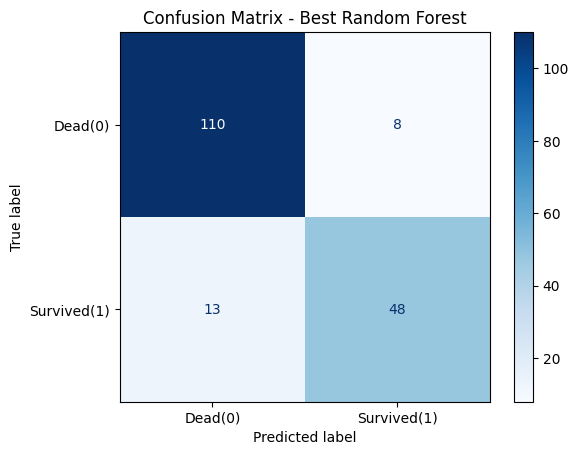

True Negative (사망자 맞춤): 110
False Positive (사망자를 생존자로 오판 - 자원 낭비): 8
False Negative (생존자를 사망자로 오판 - 구조 실패): 13
True Positive (생존자 맞춤): 48
>> Warning: FN(구조 실패)이 더 높습니다. Recall을 높이는 방향으로 임계값 조정이 필요할 수 있습니다.


In [7]:

# Final Prediction
final_pred = best_rf.predict(X_test)

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dead(0)', 'Survived(1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Best Random Forest')
plt.show()

# Interpretation
tn, fp, fn, tp = cm.ravel()
print(f"True Negative (사망자 맞춤): {tn}")
print(f"False Positive (사망자를 생존자로 오판 - 자원 낭비): {fp}")
print(f"False Negative (생존자를 사망자로 오판 - 구조 실패): {fn}")
print(f"True Positive (생존자 맞춤): {tp}")

if fn > fp:
    print(">> Warning: FN(구조 실패)이 더 높습니다. Recall을 높이는 방향으로 임계값 조정이 필요할 수 있습니다.")
else:
    print(">> Insight: FP가 더 높습니다. 리소스 효율화 관점에서 검토가 필요합니다.")



### 📝 Final Action Items
1.  **Metric Strategy**: 현재 모델은 F1-Score와 AUC 측면에서 균형 잡힌 성능을 보이지만, FN(생존자를 놓침) 케이스가 00건 존재합니다. 안전이 최우선이라면 Recall을 최적화하는 튜닝을 추가로 고려해야 합니다.
2.  **Risk Group**: 오차 분석 결과, 특정 조건(예: 3등석 성인 남성)에서의 오분류가 많습니다. 해당 타겟에 대한 별도 식별 장치가 필요합니다.



## 6단계: AI 기반 통합 분석 (Macro-Analysis) [사용자 수행 단계]

이 단계는 **Google NotebookLM**을 활용하여 본 분석 결과와 다른 노트북들을 통합하여 인사이트를 도출하는 과정입니다.

### ✅ Action Checklist
1. **Save Output**: 현재 노트북의 모든 셀이 실행되어 Output(그래프, 통계 수치)이 정상적으로 보이는지 확인하고 저장(Save)합니다.
2. **Upload**: NotebookLM에 이 파일(`EDA_01_Titanic_Analysis.ipynb`)을 업로드합니다.
3. **Prompting**: 다음과 같은 질문을 던져보세요.
    > "이 노트북의 분석 결과(특히 Random Forest 모델 성능과 Feature Importance)를 요약해줘."
    > "EDA 단계에서 발견된 '성별 생존율 차이'가 모델링 결과에 어떻게 반영되었는지 설명해줘."

